In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import requests
from PIL import Image
from io import BytesIO
import os
import sys
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from utils.image_utils import calculate_average_hsl_cv2
from sklearn.linear_model import LinearRegression

csv_files = glob.glob("../data/requests/*.csv")

# check data (if required, implement replacement of missing view counts or their data points)
for c in csv_files:
    df = pd.read_csv(c)
    for index, row in df.iterrows():
        image_url = row['thumbnail-url']
        views = row['viewCount']
        
        if len(image_url) < 10:
            print(f"Entry {index} in {os.path.basename(c)} has no thumbnail URL, please fix it manually!")
        try:
            views = int(views)
            views = str(views)
        except:
            views = ""
        if len(views) == 0:
            print(f"Entry {index} in {os.path.basename(c)} has no view count, please check this manually!")


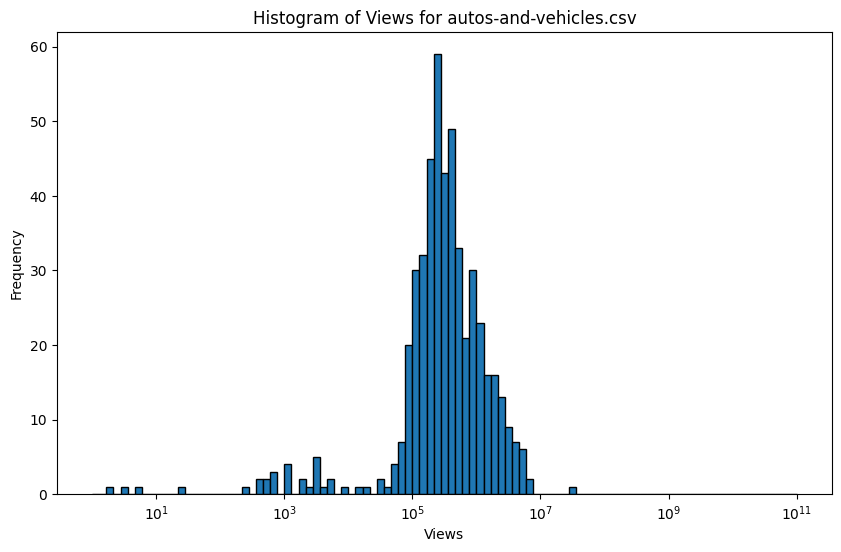

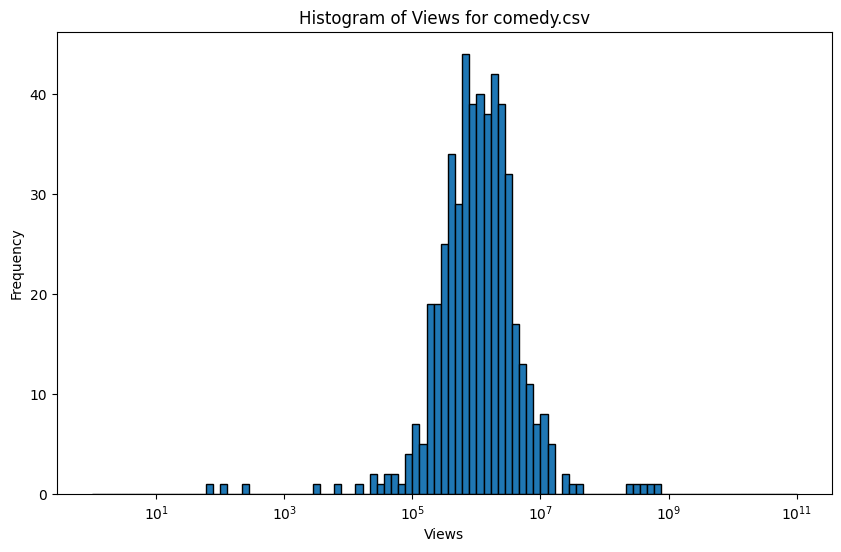

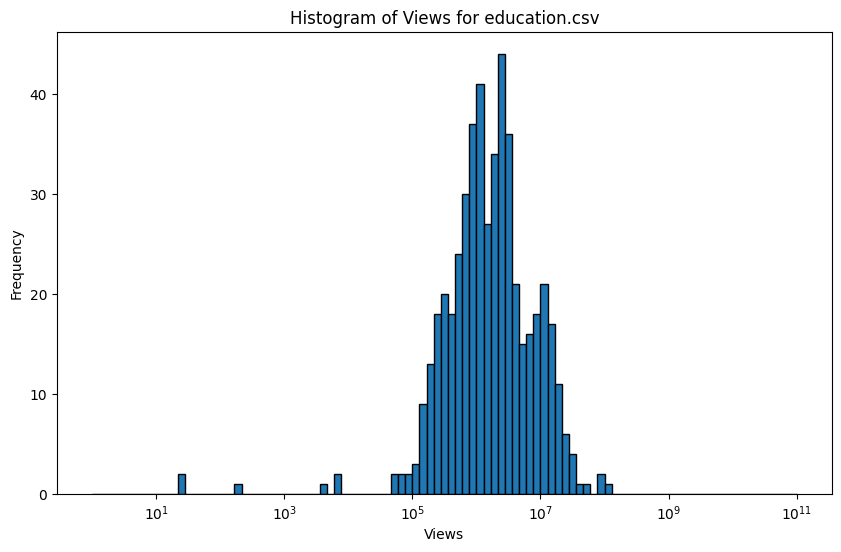

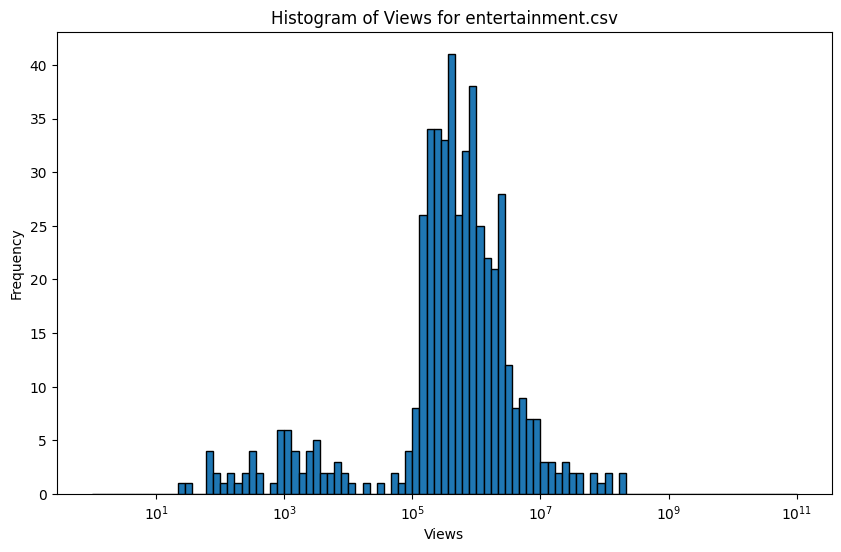

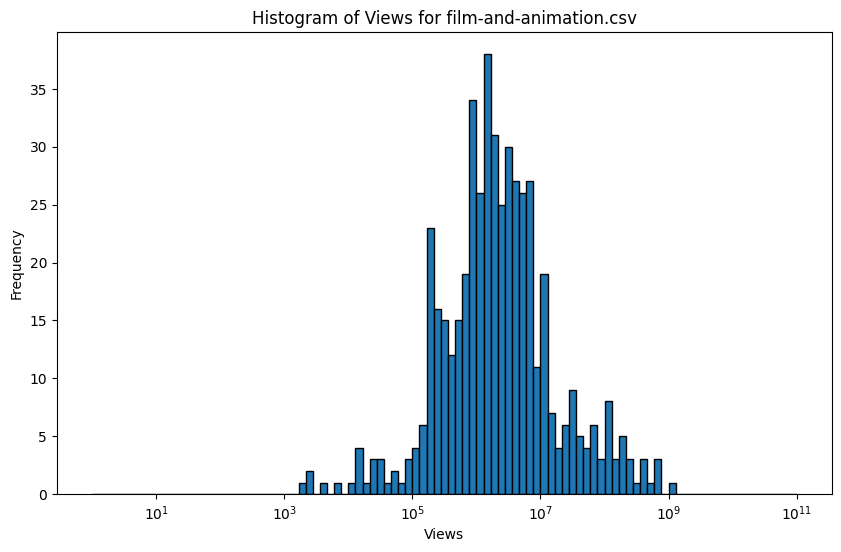

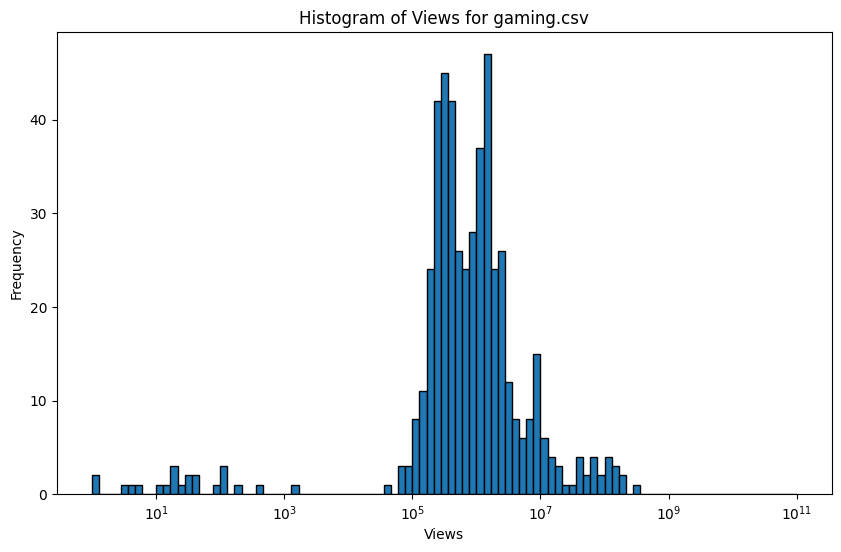

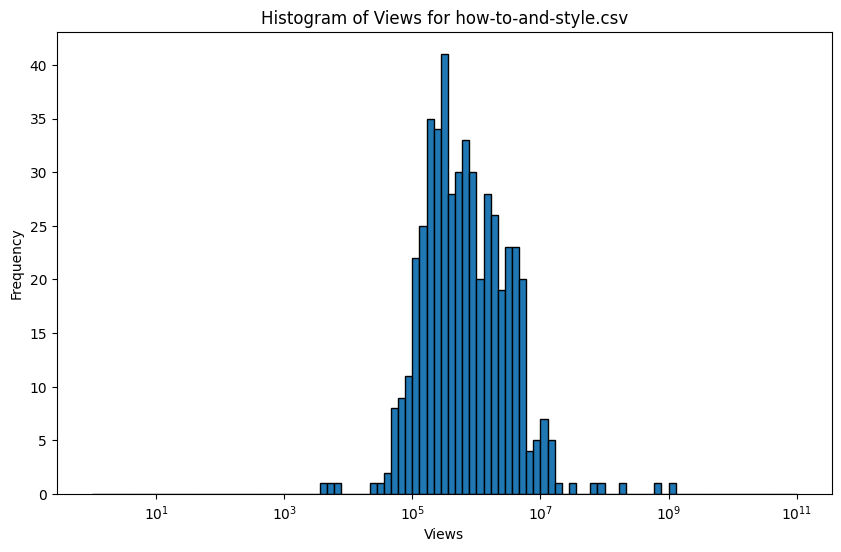

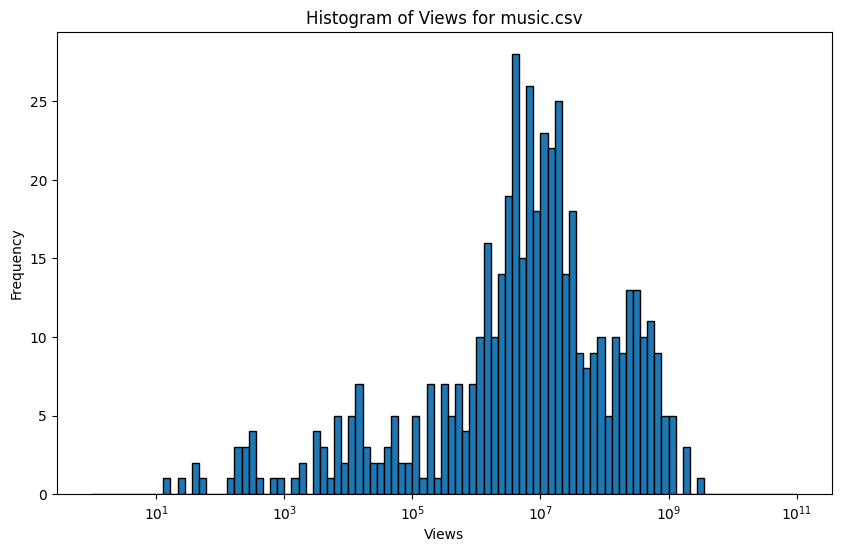

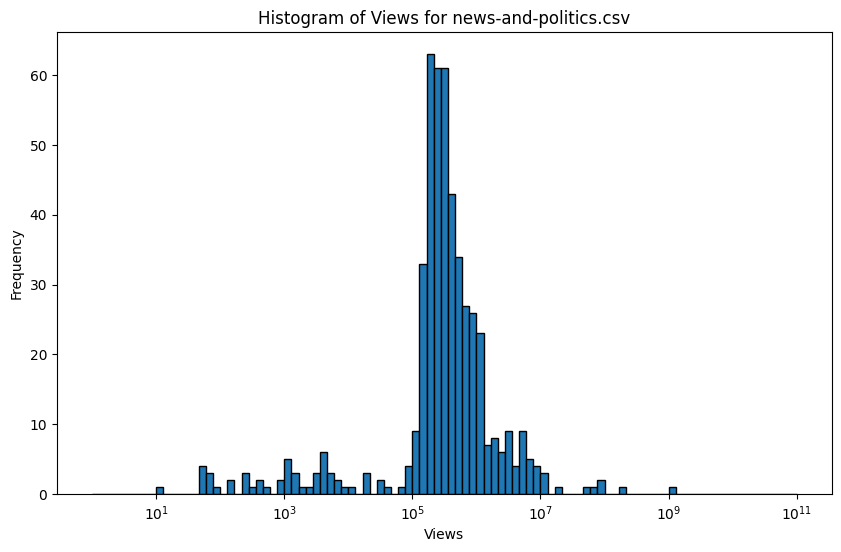

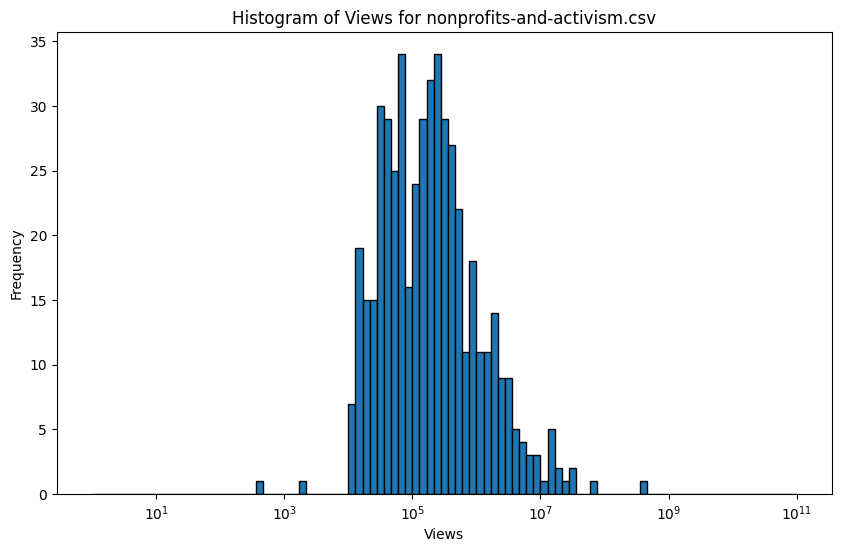

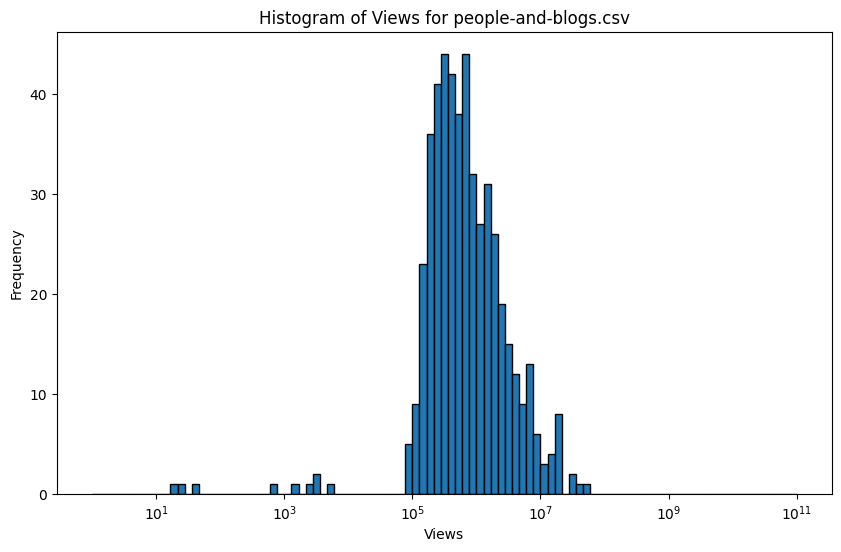

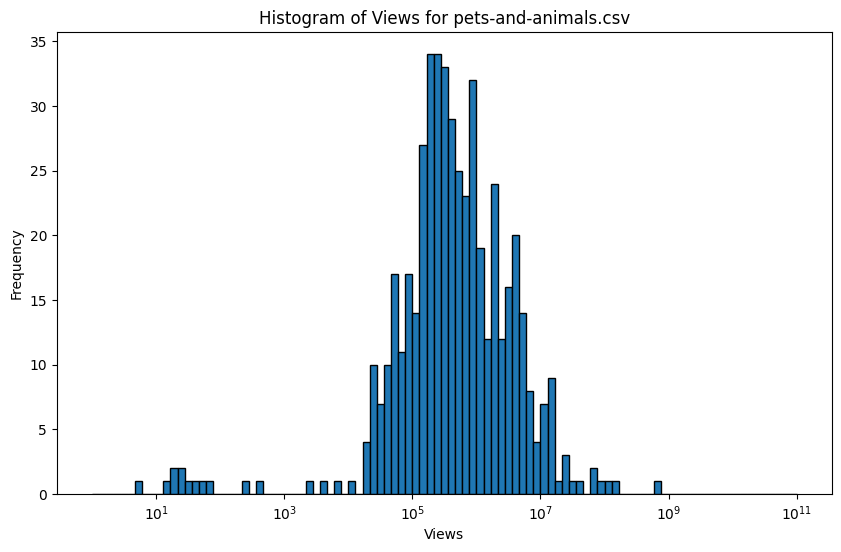

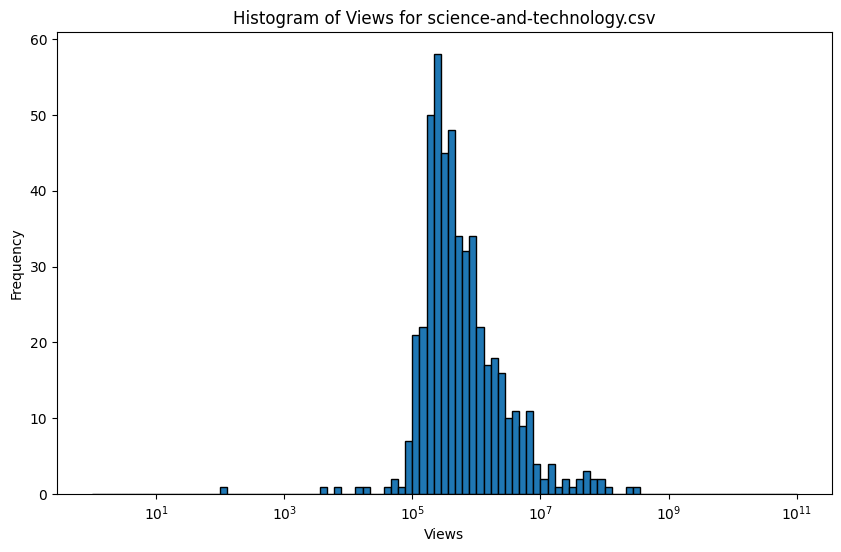

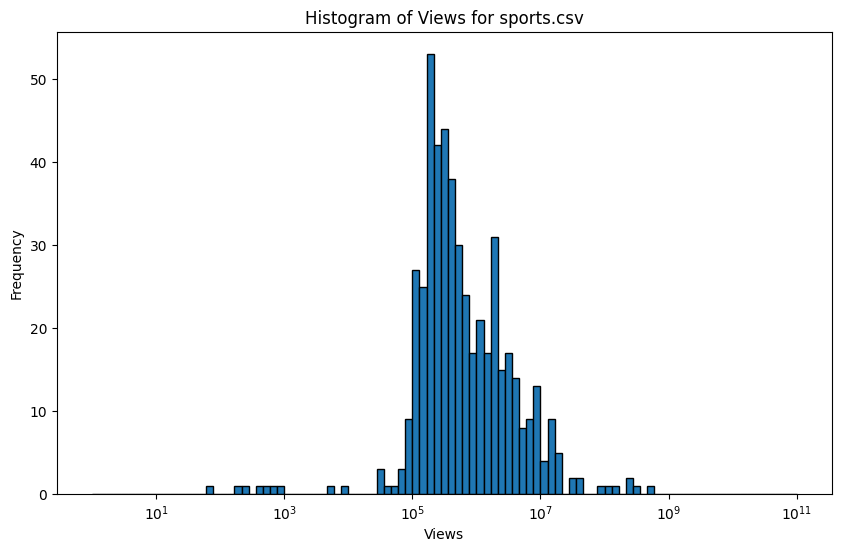

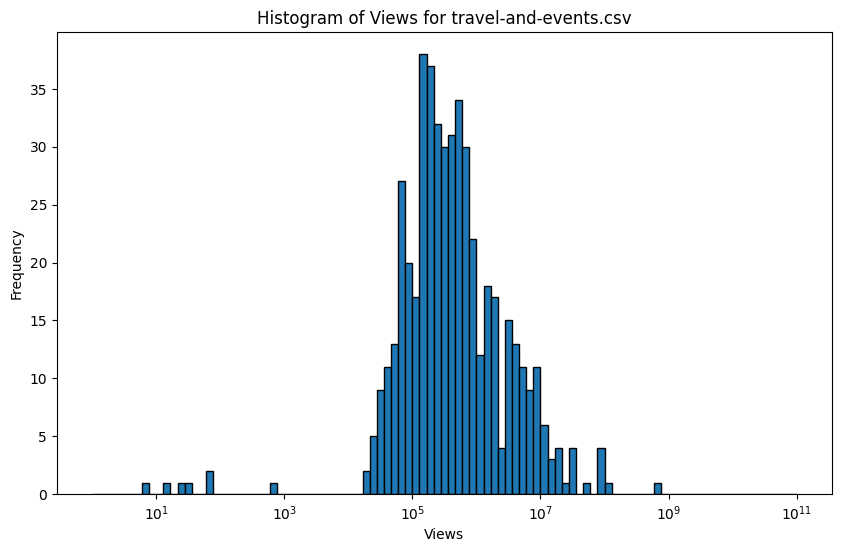

In [6]:
# like count histograms

for file in csv_files:
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Extract the 'views' column
    views = df['viewCount']
    
    # Define exponential bins
    #bins = [0, 1000, 10000, 100000, 500000, 1000000, 10000000, 100000000, 1000000000, np.inf]
    bins = np.logspace(0,11,num=100)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(views, bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.xlabel('Views')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Views for {os.path.basename(file)}')
    plt.show()

Adding filtering logic here

In [15]:
def filter_views(df, threshold=10000):
    return df[df['viewCount'] >= threshold]

Initial thumbnail analysis

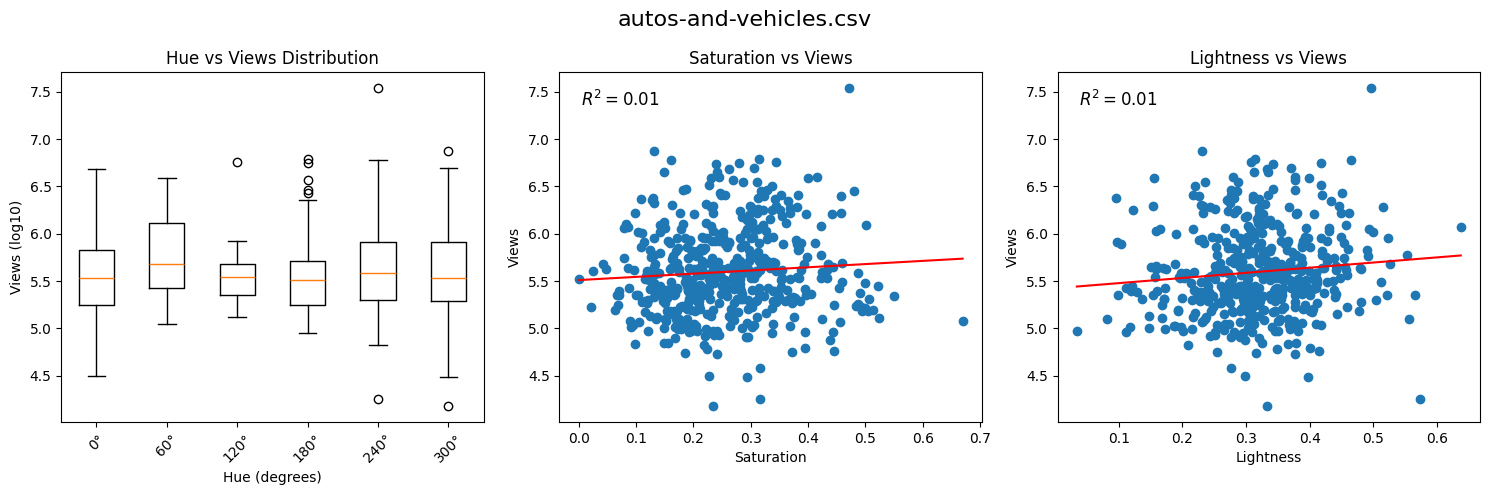

Error processing image at index 465 from https://i.ytimg.com/vi/CVWZQAlCLwI/hqdefault.jpg: Failed to download image from https://i.ytimg.com/vi/CVWZQAlCLwI/hqdefault.jpg


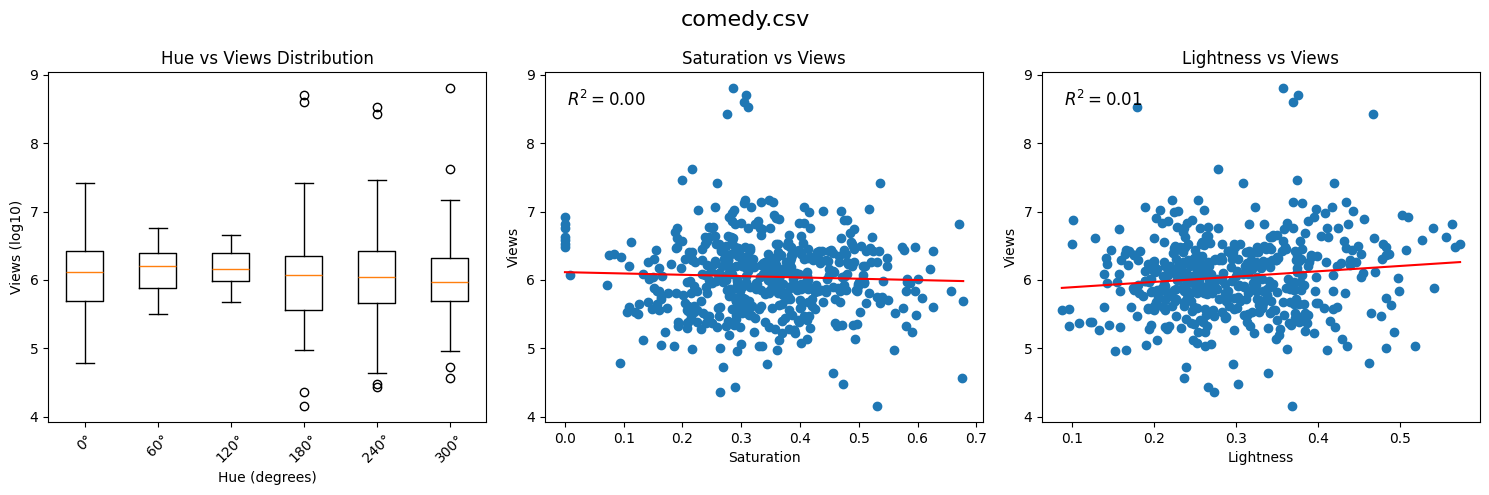

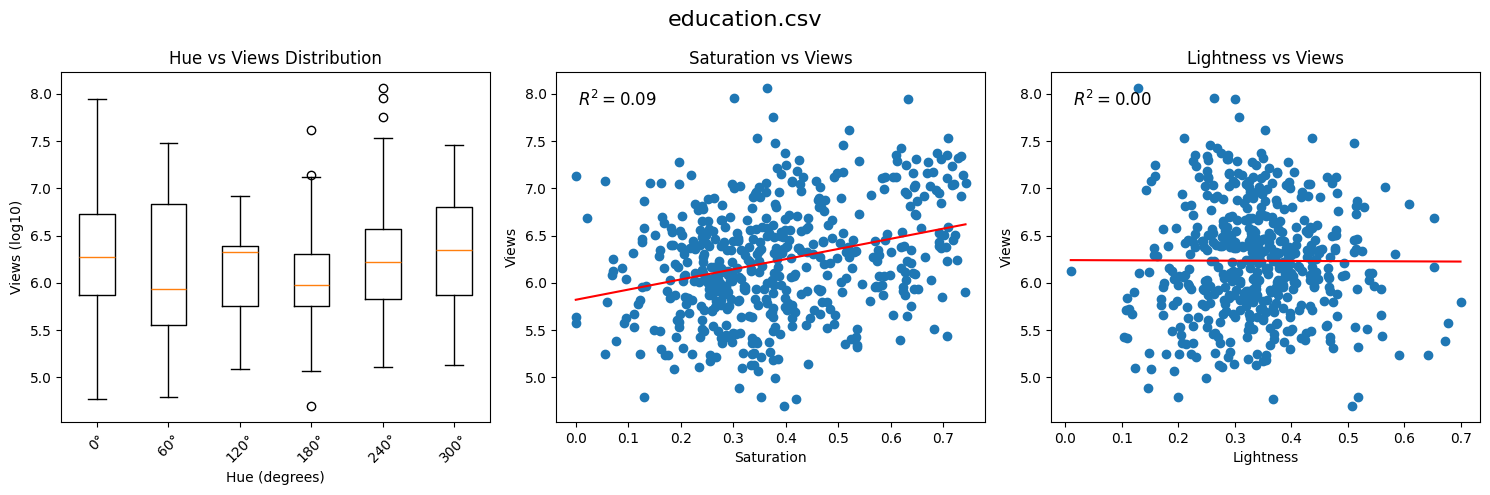

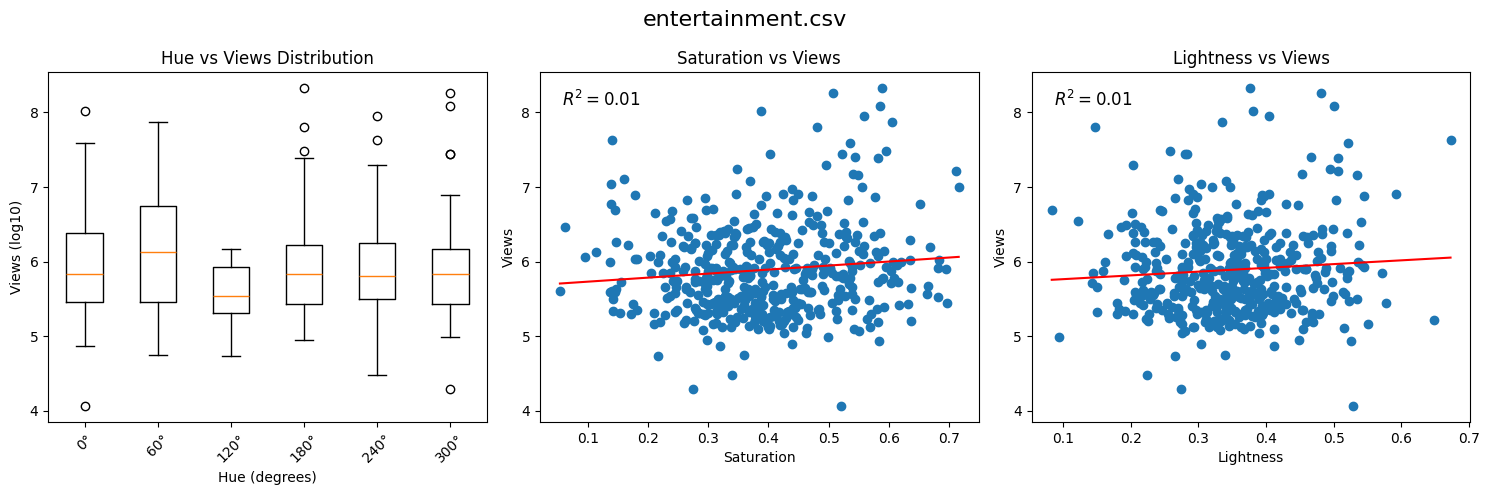

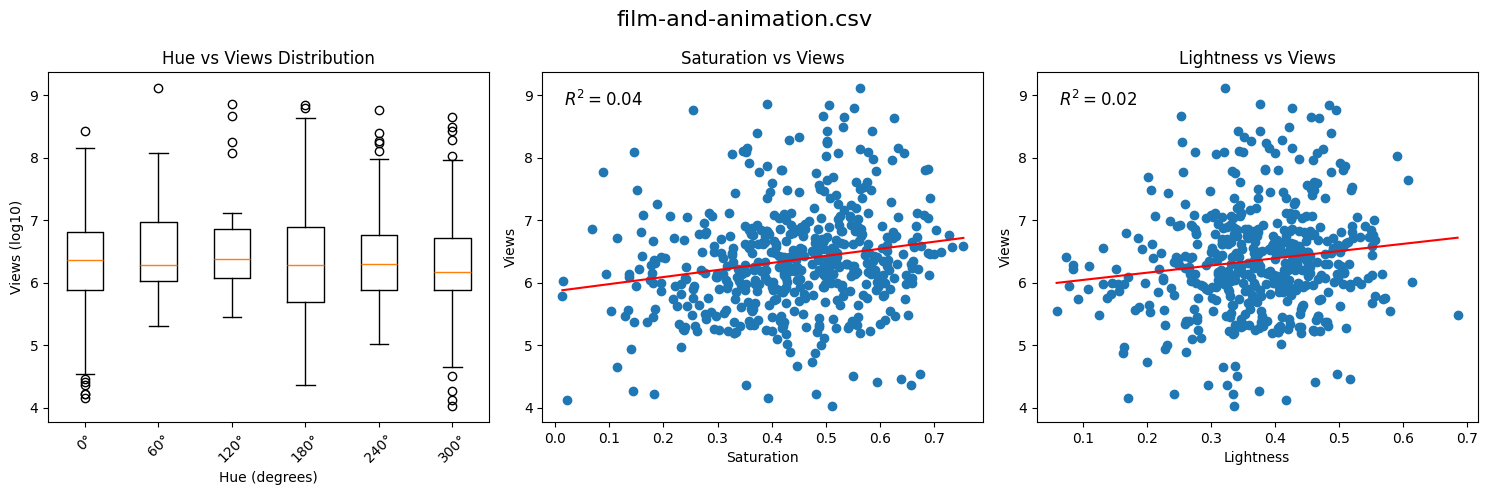

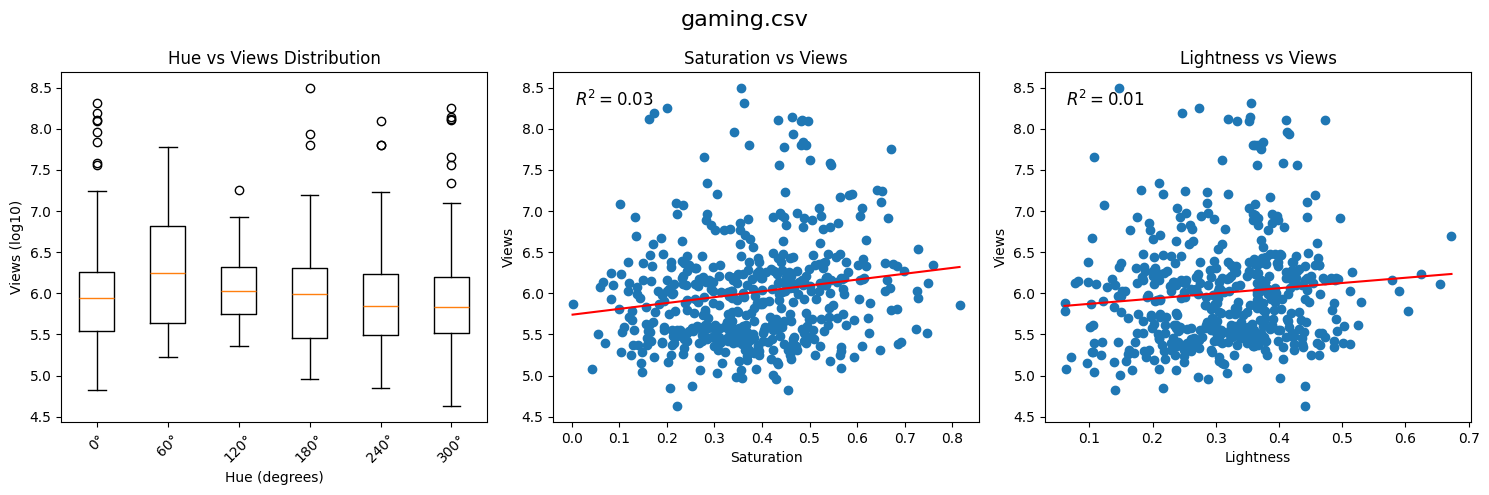

Error processing image at index 282 from https://i.ytimg.com/vi/6_wujYoVm94/hqdefault.jpg: Failed to download image from https://i.ytimg.com/vi/6_wujYoVm94/hqdefault.jpg


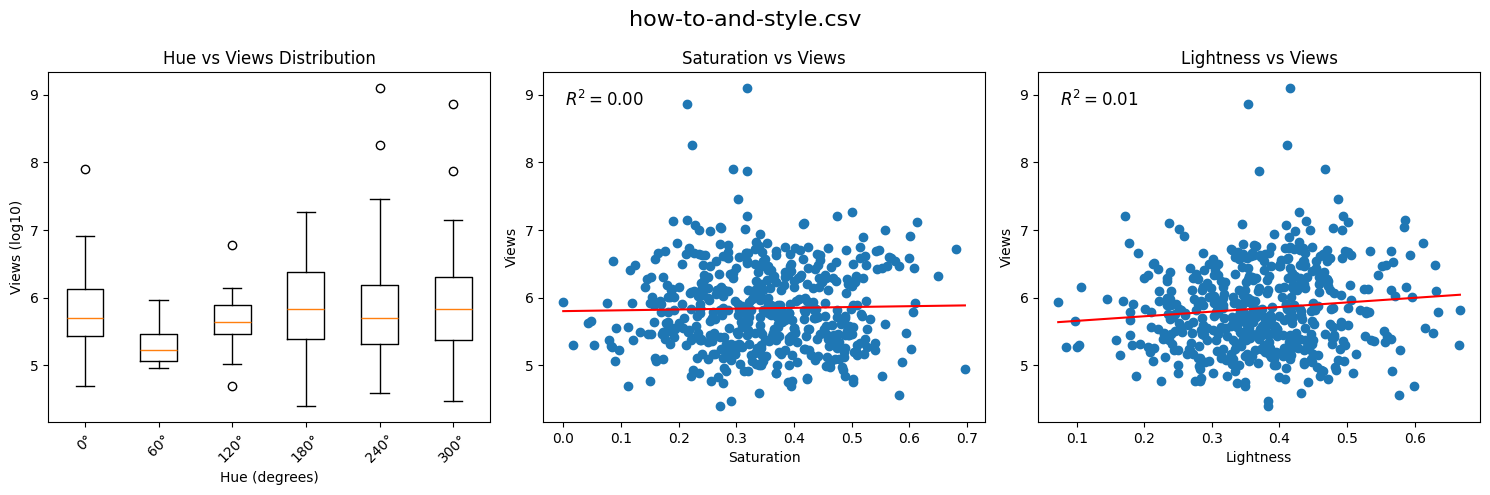

Error processing image at index 377 from https://i.ytimg.com/vi/qExyo2klBPo/hqdefault_live.jpg: Failed to download image from https://i.ytimg.com/vi/qExyo2klBPo/hqdefault_live.jpg


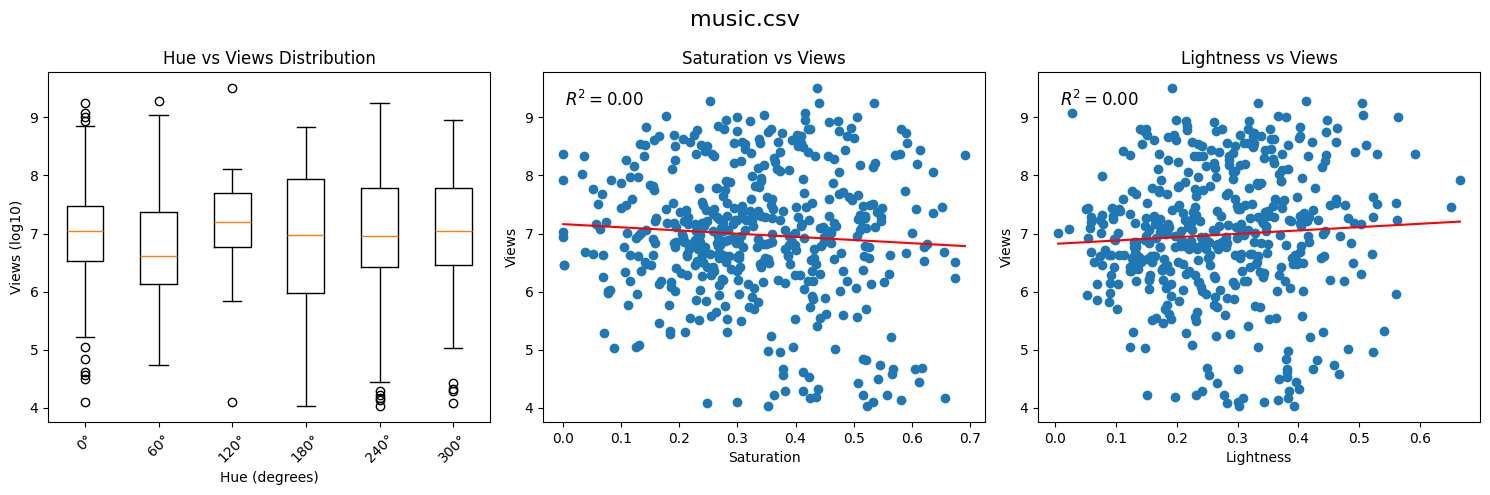

Error processing image at index 328 from https://i.ytimg.com/vi/h1IJFV9LE4Y/hqdefault.jpg: Failed to download image from https://i.ytimg.com/vi/h1IJFV9LE4Y/hqdefault.jpg


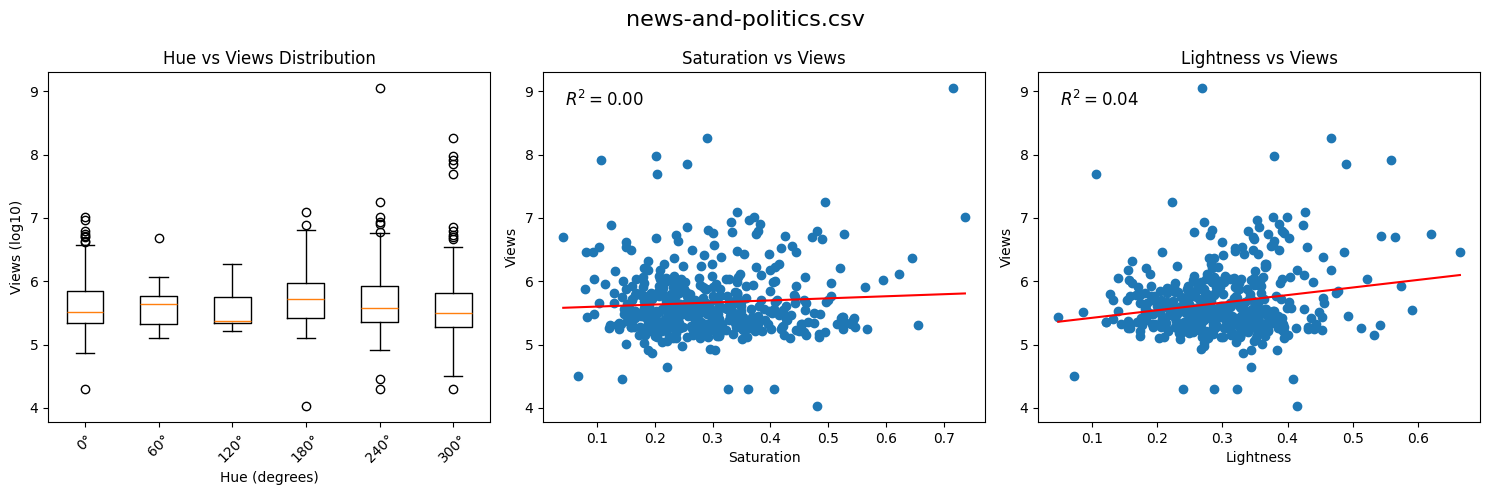

Error processing image at index 28 from https://i.ytimg.com/vi/yJmpNCrFsRo/hqdefault.jpg: Failed to download image from https://i.ytimg.com/vi/yJmpNCrFsRo/hqdefault.jpg


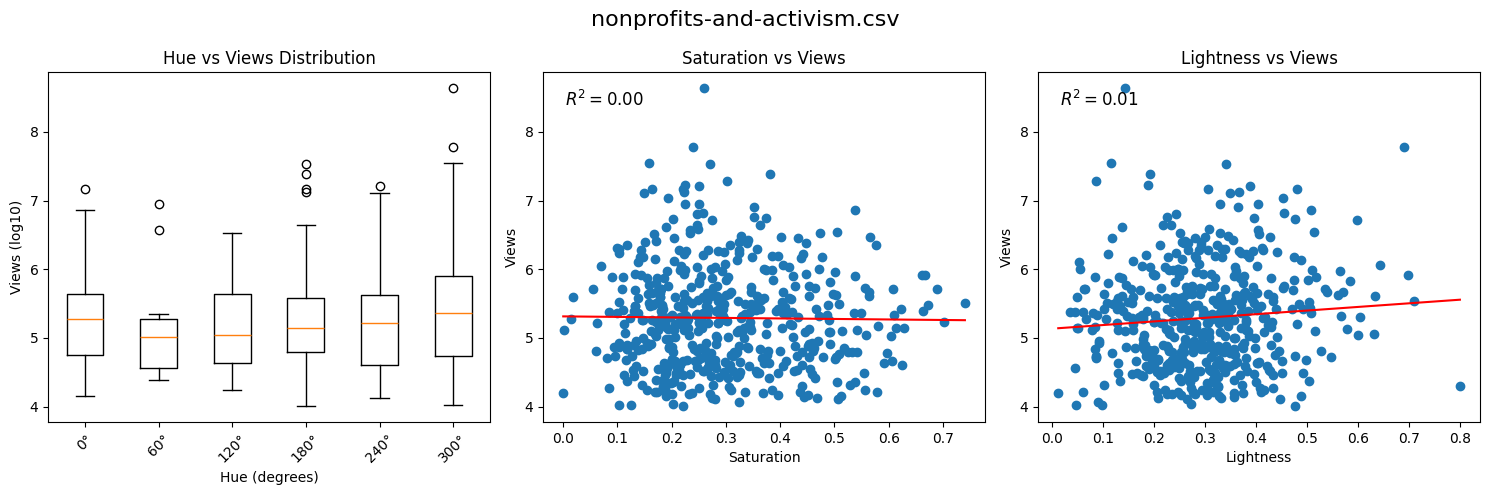

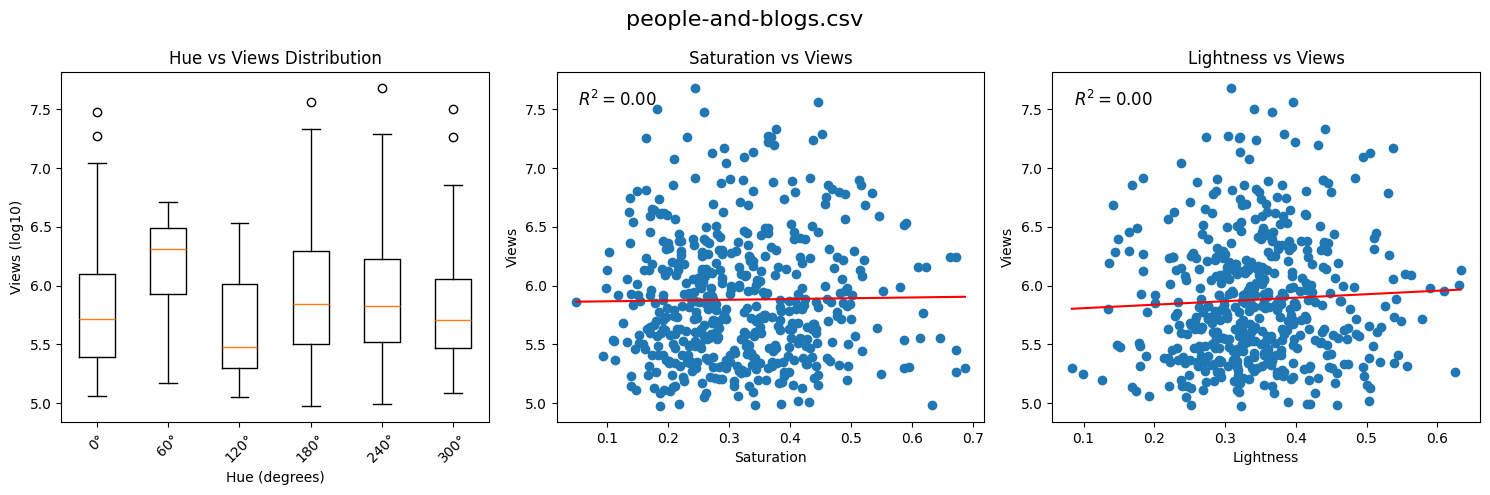

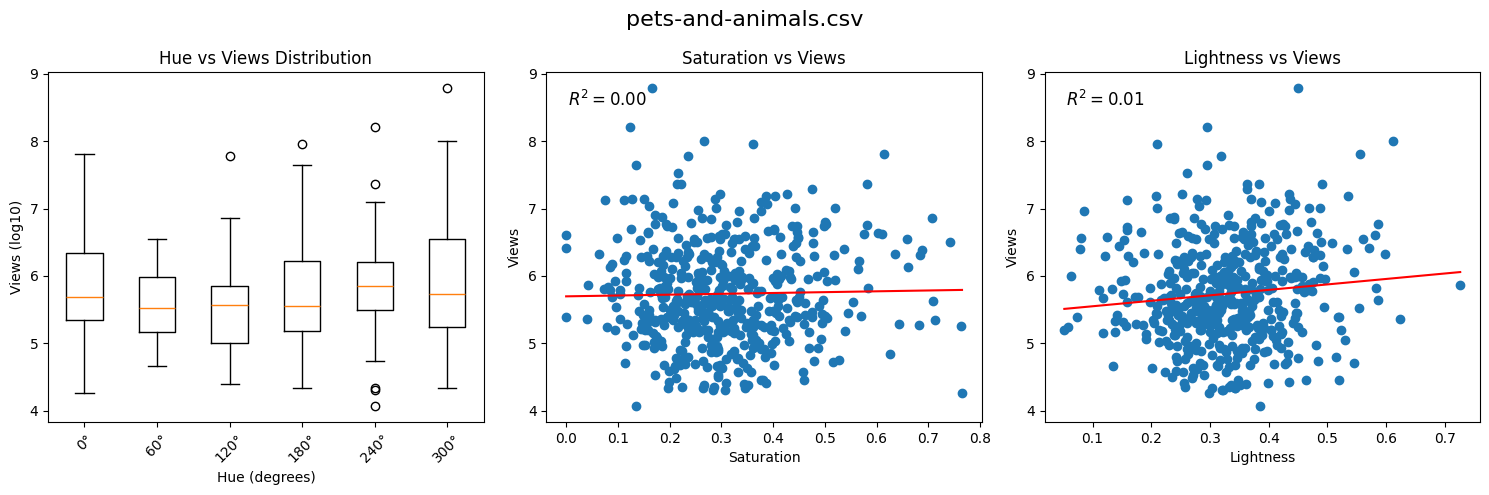

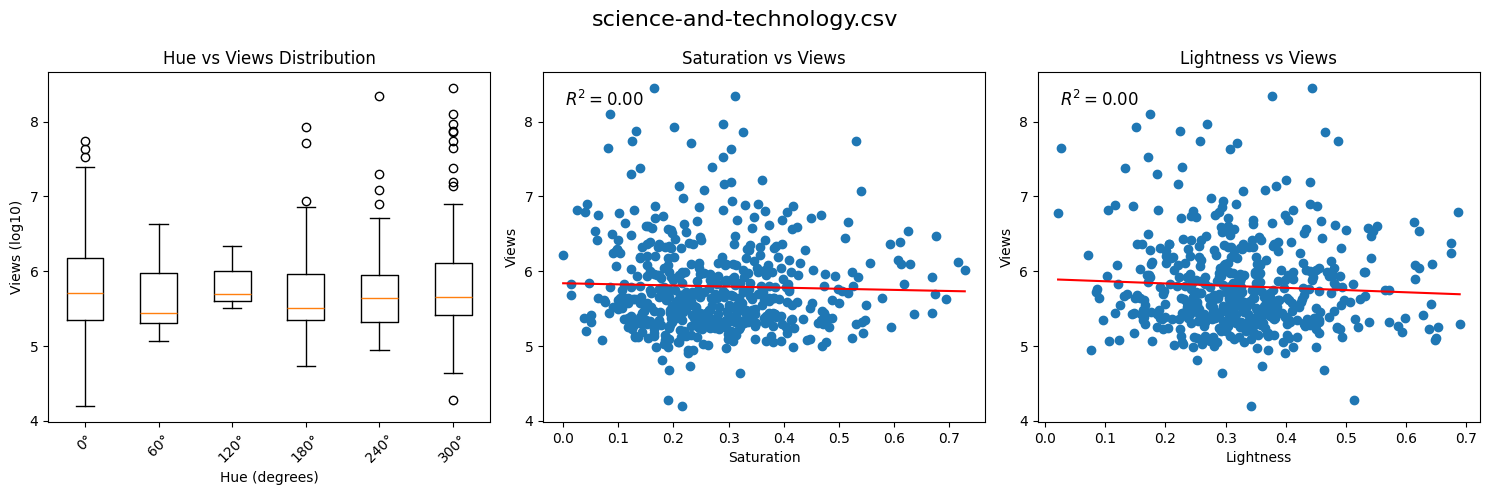

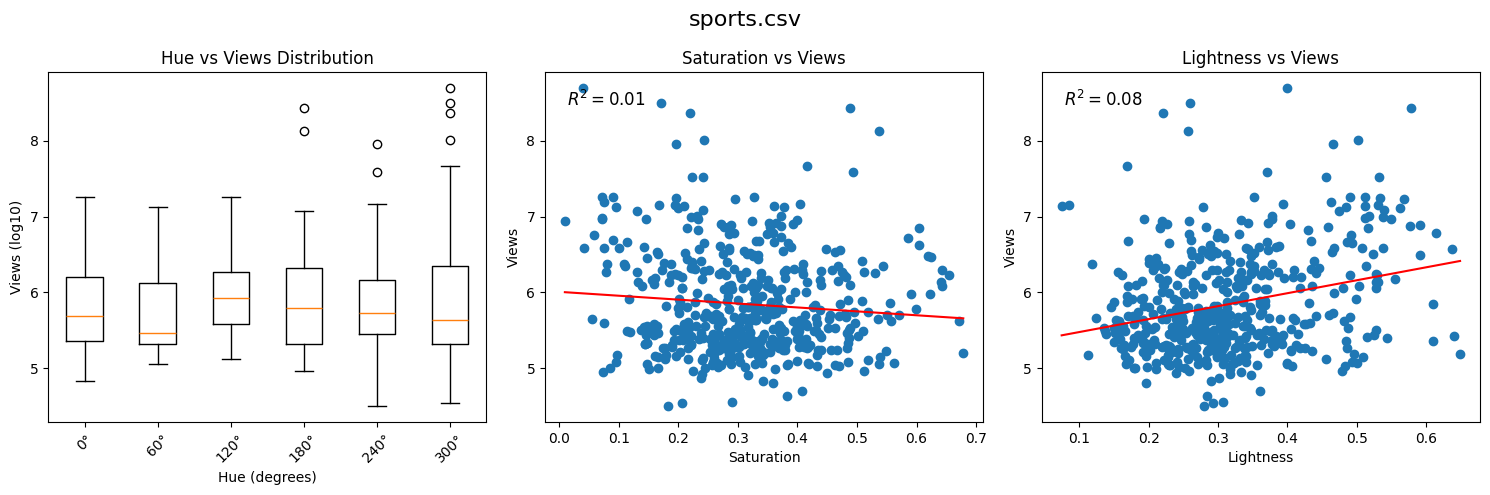

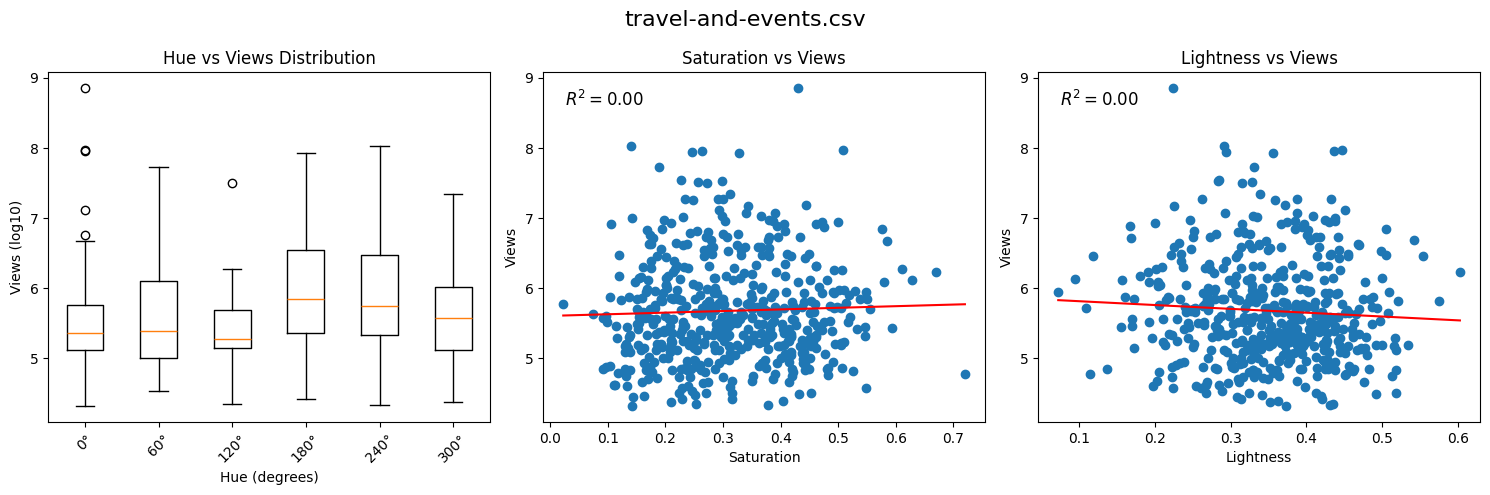

In [25]:
def download_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        raise Exception(f"Failed to download image from {url}")

def delete_image(image_path):
    if os.path.exists(image_path):
        os.remove(image_path)
    else:
        print(f"The file {image_path} does not exist")

def plot_image_values(filename, hue, saturation, lightness, views):
    plt.figure(figsize=(15, 5))

    def plot_and_fit(x, y, xlabel, title, subplot_index):
        plt.subplot(1, 3, subplot_index)
        plt.scatter(x, y)
        plt.xlabel(xlabel)
        plt.ylabel('Views')
        plt.title(title)

        # Sort the data (regression line needs this)
        sorted_indices = np.argsort(x)
        x_sorted = np.array(x)[sorted_indices]
        y_sorted = np.array(y)[sorted_indices]

        model = LinearRegression()
        x_reshaped = x_sorted.reshape(-1, 1)
        model.fit(x_reshaped, y_sorted)
        y_pred = model.predict(x_reshaped)
        plt.plot(x_sorted, y_pred, color='red')

        # Calculate R²
        r_squared = model.score(x_reshaped, y_sorted)
        plt.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    def plot_hue_boxplot(hue, views, subplot_index):
        plt.subplot(1, 3, subplot_index)
        
        # Create 6 bins (60 degrees each)
        bins = np.arange(0, 361, 60)
        bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
        
        # Bin the hues
        hue_bins = np.digitize(hue, bins) - 1
        
        # Create list of views for each bin
        binned_views = [views[hue_bins == i] for i in range(6)]
        
        # Create boxplot
        plt.boxplot(binned_views, tick_labels=[f"{bins[i]:d}°" for i in range(6)])
        
        plt.xlabel('Hue (degrees)')
        plt.ylabel('Views (log10)')
        plt.title('Hue vs Views Distribution')
        plt.xticks(rotation=45)

    views = np.log10(np.array(views) + 1)  # Log transform views
    
    # Plot hue with binning
    plot_hue_boxplot(hue, views, 1)
    
    # Plot saturation and lightness with regression (unchanged)
    plot_and_fit(saturation, views, 'Saturation', 'Saturation vs Views', 2)
    plot_and_fit(lightness, views, 'Lightness', 'Lightness vs Views', 3)

    plt.suptitle(filename, fontsize=16)
    plt.tight_layout()
    plt.show()

for c in csv_files:
    df = pd.read_csv(c)
    df = filter_views(df, 10000)
    
    # Check if HSL columns exist, if not create them
    hsl_columns = ['hue', 'saturation', 'lightness']
    for col in hsl_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    # Track if we need to save changes
    needs_update = False
    
    hue, saturation, lightness, views = [], [], [], []
    
    for index, row in df.iterrows():
        # Check if we already have HSL values
        if pd.notna(row['hue']) and pd.notna(row['saturation']) and pd.notna(row['lightness']):
            hue.append(row['hue'])
            saturation.append(row['saturation'])
            lightness.append(row['lightness'])
        else:
            # Need to download and process image
            try:
                image = download_image(row['thumbnail-url'])
                result = calculate_average_hsl_cv2(np.array(image))
                
                # Store values in lists for plotting
                hue.append(result['hue'])
                saturation.append(result['saturation'])
                lightness.append(result['lightness'])
                
                # Update DataFrame
                df.at[index, 'hue'] = result['hue']
                df.at[index, 'saturation'] = result['saturation']
                df.at[index, 'lightness'] = result['lightness']
                
                needs_update = True
            except Exception as e:
                print(f"Error processing image at index {index} from {row['thumbnail-url']}: {e}")
                # Add NaN values to maintain list length
                hue.append(np.nan)
                saturation.append(np.nan)
                lightness.append(np.nan)
        
        views.append(row['viewCount'])
    
    # Save updated DataFrame if changes were made
    if needs_update:
        df.to_csv(c, index=False)
    
    # Remove NaN values before plotting
    valid_indices = ~(np.isnan(hue) | np.isnan(saturation) | np.isnan(lightness) | np.isnan(views))
    hue = np.array(hue)[valid_indices]
    saturation = np.array(saturation)[valid_indices]
    lightness = np.array(lightness)[valid_indices]
    views = np.array(views)[valid_indices]
    
    if len(views) > 0:  # Only plot if we have valid data
        plot_image_values(os.path.basename(c), hue, saturation, lightness, views)
